# 1. Retrieving CAPE data

The following code specifically uses classes from the COGS department for the purpose of walking through the process of extracting data from CAPE. We will be combining the code into a method which will iterate through each of the departments and retrieve data from each of the other departments.

### 1a. Import the packages we need to retrieve the dataset

The packages **urllib** and **urllib2** are used to create an appropriately formatted URL for retrieving the targeted data.  
**BeautifulSoup** is used to capture and parse the retrieved HTML to extract the table data.

In [1]:
from bs4 import BeautifulSoup
from urllib import urlencode
import urllib2

### 1b. Define some variables to control the scope of our data request

1. **name** - If provided, must be in format "Last_Name, First_Name (Middle_Name)"
2. **course** - If provided, must be in in format "DEPT xxx"
    1. Not providing a course number returns data for all courses in the department.
    2. Entering "COGS 1" also returns data for COGS 11, 14A, 14B, 100, etc. There is no known way around this.
3. **base** and **errors** are fixed values and should not be modified

In [2]:
name = ""
course = "COGS"

# To be suffixed by input values of name and course
base = "http://cape.ucsd.edu/responses/Results.aspx?"
# Common error messages returned by CAPE
errors = [ \
    "No CAPEs have been submitted that match your search criteria.",
    "Please enter your search criteria"
]

### 1c. Request the specified data from CAPE
Create the appropriate URL from input values provided above and capture the response HTML into BeautifulSoup

In [3]:
link = base + urlencode(zip(["Name", "CourseNumber"], [name, course]))

opener = urllib2.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
handler = opener.open(link)

soup = BeautifulSoup(handler, "lxml", from_encoding="utf-8")
print "Retrieved HTML from", link

Retrieved HTML from http://cape.ucsd.edu/responses/Results.aspx?Name=&CourseNumber=COGS


# 2. Transform the response HTML into a pandas DataFrame

**Note:** This code was written before I discovered the read_html method of the **pandas** library, which already implements much of the following logic.

`pd.read_html(str(soup), flavor='bs4')`

In [4]:
import pandas as pd

# Retrieve each of the table's rows
selector = lambda classes: 'odd' in classes or 'even' in classes
classes = soup.tr.find_all_next("tr", class_=selector)

# Extract column names
header = [ col.string.lower() for col in soup.tr.contents if col.name == "th" and col.has_attr('scope') ]

results = []
# Extract column values from each of the retrieved rows
for line in classes:
    values = filter(lambda col: col.name == "td", line.contents)
    values = [ v.text.strip() for v in values ]
    results.append(values)

df = pd.DataFrame(results, columns=header)

# 3. Tidying the extracted dataset

So far, so good.  
Let's take a look at our data!

In [5]:
df.info()
df.describe(include=['object'])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 760 entries, 0 to 759
Data columns (total 10 columns):
instructor            760 non-null object
course                760 non-null object
term                  760 non-null object
enroll                760 non-null object
evals made            760 non-null object
rcmnd class           760 non-null object
rcmnd instr           760 non-null object
study hrs/wk          760 non-null object
avg grade expected    760 non-null object
avg grade received    760 non-null object
dtypes: object(10)
memory usage: 59.4+ KB


,instructor,course,term,enroll,evals made,rcmnd class,rcmnd instr,study hrs/wk,avg grade expected,avg grade received
count,760,760,760,760,760,760,760,760,760,760
unique,90,173,45,225,142,218,224,367,105,141
top,"Boyle, Mary E. T.",No CAPEs submitted,WI13,1,0,100.0 %,100.0 %,N/A,A (4.00),N/A
freq,86,41,37,22,41,222,259,41,93,271


In [6]:
df[:5]

,instructor,course,term,enroll,evals made,rcmnd class,rcmnd instr,study hrs/wk,avg grade expected,avg grade received
0,"Boyle, Mary E. T.",COGS 1 - Introduction to Cognitive Sci (A),WI17,370,173,85.5 %,57.2 %,5.07,B (3.12),B (3.11)
1,"Kirsh, David Joel",COGS 100 - Cyborgs Now and in the Future (A),WI17,97,47,46.5 %,55.8 %,4.55,B (3.28),B (3.23)
2,"Walker, Esther Jane",COGS 101A - Sensation and Perception (A),WI17,90,39,97.3 %,100.0 %,5.47,B+ (3.67),B (3.24)
3,"Barrera, Steven James","COGS 101B - Learning, Memory and Attention (A)",WI17,368,197,95.7 %,99.5 %,5.09,B+ (3.52),B (3.29)
4,"Johnson, Christine M.",COGS 102B - Cognitive Ethnography (A),WI17,108,42,43.6 %,43.6 %,6.04,A- (3.72),B+ (3.69)


Not too bad, but it looks like we're going to have to take some steps to clean the dataset.

### 3a. Standardizing null values

It seems that we haven't accounted for "null" values (see columns **course**, **evals made**, **study hrs/wk** above) as a result of manually extracting our data (i.e. not using panda's read_html function). We will also drop any rows for which there were no evaluations made. ( `df[df["evals made"] == 0]` )

In [7]:
import numpy as np

for key in df.keys():
    df[key].replace("N/A", np.nan, inplace=True)

no_evals = df["evals made"] == "0"
print "Dropping", len(df[no_evals]), "rows with 0 CAPE evaluations"

df = df[~no_evals].reset_index(drop=True)

Dropping 41 rows with 0 CAPE evaluations


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 719 entries, 0 to 718
Data columns (total 10 columns):
instructor            719 non-null object
course                719 non-null object
term                  719 non-null object
enroll                719 non-null object
evals made            719 non-null object
rcmnd class           719 non-null object
rcmnd instr           719 non-null object
study hrs/wk          719 non-null object
avg grade expected    692 non-null object
avg grade received    489 non-null object
dtypes: object(10)
memory usage: 56.2+ KB


### 3b. Tidying up data entries and transforming data formats

The data formats for columns **course**, **avg grade expected**, **avg grade received** need to be reformatted as tidy data.

In [9]:
import re

# Extracting course number - "COGS 102A - Distributed Cognition (A)" becomes "COGS 102A"
course = re.compile("([A-Z]+ [0-9]+[A-Z]?)")
df["course"] = df["course"].str.extract(course, expand=False)

# All values under "term" are in format XXYY, where XX refers to the term and YY refers to the year
# Change values to follow format YYX s.t. YYX is a single value (we want FA15 to be greater than SP13)
quarters = { "FA": 0., "WI": 2.5, "SP": 5., "S1": 7.5, "S2": 7.5, "S3": 7.5, "SU": 7.5 }
df["term"] = df["term"].apply(lambda term: (10 * float(term[2:])) + quarters[term[:2]])

# Convert to numeric type
for key in ["enroll", "evals made", "study hrs/wk"]:
    df[key] = pd.to_numeric(df[key])

# Strip off percentage signs and convert to numeric type
rcmnd_filter = lambda x: x if pd.isnull(x) else float(x.rstrip(" %"))
df["rcmnd class"] = df["rcmnd class"].apply(rcmnd_filter)
df["rcmnd instr"] = df["rcmnd instr"].apply(rcmnd_filter)

# Strip off letter grade and convert to numeric type
grades = re.compile("[A-Z][-+]? \((.*)\)")
grade_filter = lambda x: x if pd.isnull(x) else float(grades.match(x).groups()[0])
df["avg grade expected"] = df["avg grade expected"].apply(grade_filter)
df["avg grade received"] = df["avg grade received"].apply(grade_filter)

df[:5]

,instructor,course,term,enroll,evals made,rcmnd class,rcmnd instr,study hrs/wk,avg grade expected,avg grade received
0,"Boyle, Mary E. T.",COGS 1,172.5,370,173,85.5,57.2,5.07,3.12,3.11
1,"Kirsh, David Joel",COGS 100,172.5,97,47,46.5,55.8,4.55,3.28,3.23
2,"Walker, Esther Jane",COGS 101A,172.5,90,39,97.3,100.0,5.47,3.67,3.24
3,"Barrera, Steven James",COGS 101B,172.5,368,197,95.7,99.5,5.09,3.52,3.29
4,"Johnson, Christine M.",COGS 102B,172.5,108,42,43.6,43.6,6.04,3.72,3.69


# 4. Code condensation
Much better! Now let's review by starting over and compiling all of this code into a few "simple" functions.

# Note: Enter 'y' in the dialog below to reset the environment

In [10]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [11]:
from bs4 import BeautifulSoup
from urllib import urlencode
import sys, urllib2
import pandas as pd
import numpy as np
import re

def get_website(link):
    # Prepare URL request
    opener = urllib2.build_opener()
    opener.addheaders = [('User-agent', 'Mozilla/5.0')]
    print "Fetching contents from", link
    handler = opener.open(link)
    return BeautifulSoup(handler, "lxml", from_encoding="utf-8")

def get_cape(params):
    errors = [ \
        "No CAPEs have been submitted that match your search criteria.",
        "Please enter your search criteria"
    ]

    base = "http://cape.ucsd.edu/responses/Results.aspx?"

    # urlencode maps None as "None"
    params = map(lambda d: d if d else '', params)
    data = urlencode(zip(["Name", "CourseNumber"], params))

    # Validate whether CAPE data is available
    soup = get_website(base + data)
    for e in errors:
        if e in str(soup.tr.contents):
            return None

    return soup

def parse_cape(soup):
    # Retrieve each of the table's rows
    selector = lambda classes: 'odd' in classes or 'even' in classes
    classes = soup.tr.find_all_next("tr", class_=selector)

    # Extract column names
    header = [ col.string.lower() for col in soup.tr.contents if col.name == "th" and col.has_attr('scope') ]

    results = []
    # Extract column values from each of the retrieved rows
    for line in classes:
        values = filter(lambda col: col.name == "td", line.contents)
        values = [ v.text.strip() for v in values ]
        results.append(values)

    ###############################################
    
    df = pd.DataFrame(results, columns=header)

    for key in df.keys():
        df[key].replace("N/A", np.nan, inplace=True)

    no_evals = df["evals made"] == "0"
    print "Dropping", len(df[no_evals]), "rows with 0 CAPE evaluations"

    df = df[~no_evals].reset_index(drop=True)

    # Extracting course number - "COGS 102A - Distributed Cognition (A)" becomes "COGS 102A"
    course = re.compile("([A-Z]+ [0-9]+[A-Z]?)")
    df["course"] = df["course"].str.extract(course, expand=False)

    # All values under "term" are in format XXYY, where XX refers to the term and YY refers to the year
    # Change values to follow format YYX s.t. YYX is a single value (we want FA15 to be greater than SP13)
    quarters = { "FA": 0., "WI": 2.5, "SP": 5., "S1": 7.5, "S2": 7.5, "S3": 7.5, "SU": 7.5 }
    df["term"] = df["term"].apply(lambda term: (10 * float(term[2:])) + quarters[term[:2]])

    # Convert to numeric type
    for key in ["enroll", "evals made", "study hrs/wk"]:
        df[key] = pd.to_numeric(df[key])

    # Strip off percentage signs and convert to numeric type
    rcmnd_filter = lambda x: x if pd.isnull(x) else float(x.rstrip(" %"))
    df["rcmnd class"] = df["rcmnd class"].apply(rcmnd_filter)
    df["rcmnd instr"] = df["rcmnd instr"].apply(rcmnd_filter)

    # Strip off letter grade and convert to numeric type
    grades = re.compile("[A-Z][-+]? \((.*)\)")
    grade_filter = lambda x: x if pd.isnull(x) else float(grades.match(x).groups()[0])
    df["avg grade expected"] = df["avg grade expected"].apply(grade_filter)
    df["avg grade received"] = df["avg grade received"].apply(grade_filter)

    return df

# 5. Extract CAPE data for all departments

Now that the web scraping code is separated into functions, let's retrieve all the data the CAPE has to offer.

### 5a. Retrieve a list of all department codes

Why not?

In [12]:
from urlparse import urljoin

soup = get_website("https://blink.ucsd.edu/instructors/courses/schedule-of-classes/subject-codes.html")
df = pd.read_html(str(soup), flavor='bs4')[0]

# Credits: https://stackoverflow.com/a/26147330
df.columns = df.iloc[0]
df.reindex(df.index.drop(0))

codes = df["Code"].tolist()[1:]
print "Department Codes:", ', '.join(codes)

Fetching contents from https://blink.ucsd.edu/instructors/courses/schedule-of-classes/subject-codes.html
Department Codes: AAS, AESE, AIP, ANAR, ANBI, ANES, ANSC, ANTH, AUD, BENG, BGGN, BGJC, BGRD, BGSE, BIBC, BICD, BIEB, BILD, BIMM, BIOM, BIPN, BISP, BNFO, CAT, CENG, CGS, CHEM, CHIN, CLAS, CLIN, CLRE, CLSS, CMM, COGN, COGR, COGS, COMM, CONT, COSF, CSE, DERM, DOC, DSE, DSGN, EAP, ECE, ECON, EDS, ELWR, EMED, ENG, ENVR, ERC, ESYS, ETHN, EXPR, FILM, FMPH, FPM, FPMU, GLBH, GMST, GPCO, GPEC, GPGN, GPIM, GPLA, GPPA, GPPS, HDP, HIAF, HIEA, HIEU, HIGR, HILA, HILD, HINE, HISC, HITO, HIUS, HLAW, HMNR, HUM, ICAM, ICEP, INTL, IRCO, IRGN, IRLA, JAPN, JUDA, LATI, LAWS, LHCO, LIAB, LIDS, LIEO, LIFR, LIGM, LIGN, LIHI, LIHL, LIIT, LIPO, LISL, LISP, LTAF, LTAM, LTCH, LTCO, LTCS, LTEA, LTEN, LTEU, LTFR, LTGK, LTGM, LTHE, LTIT, LTKO, LTLA, LTPR, LTRU, LTSP, LTTH, LTWL, LTWR, MAE, MATH, MATS, MBC, MCWP, MDE, MED, MGT, MGTA, MGTF, MMW, MSED, MSP, MUIR, MUS, NANO, NEU, OPTH, ORTH, PATH, PEDS, PHAR, PHIL, PHY

### 5b. Extract CAPE data for each department subject (saves files to disk!)

Most of the code below provides logic for handling the data parsed from the different department subject codes.  

For each department subject code, all of the code can be boiled down into the following lines:

    code = "COGS"
    filename = "COGS.json"
    
    open(filename, "w").write(parse_cape(get_soup(("", code))).to_json())

In [13]:
import os.path

success = []
failures = []

# '''
# These department subject codes were pre-identified as not having any CAPE data.
# We will automatically ignore these subject codes in order to save time.
# If you want to see the code at work, then uncomment the triple quotes just above and below.
null_codes = [u'AESE', u'ANES', u'AUD', u'BGGN', u'BGJC', u'BGRD', u'BGSE', u'BIOM', \
 u'BNFO', u'CLIN', u'CLRE', u'CLSS', u'CMM', u'COGR', u'DERM', u'DSE',  \
 u'EAP', u'EMED', u'EXPR', u'GMST', u'GPCO', u'GPEC', u'GPGN', u'GPIM', \
 u'GPLA', u'GPPA', u'GPPS', u'HIGR', u'HLAW', u'ICEP', u'IRCO', u'IRGN',\
 u'IRLA', u'LHCO', u'LIDS', u'LIEO', u'LIHI', u'LTCO', u'LTHE', u'LTPR',\
 u'MATS', u'MBC', u'MDE', u'MED', u'MGTA', u'MGTF', u'MSED', u'MSP',    \
 u'NEU', u'OPTH', u'ORTH', u'PATH', u'PEDS', u'PHAR', u'RAD', u'RMAS',  \
 u'RMED', u'SIOB', u'SIOC', u'SIOG', u'SOCG', u'SOMC', u'SOMI', u'SPPS',\
 u'SURG', u'TDGR', u'WES']

codes = [ c for c in codes if not c in null_codes ]
# '''

for code in codes:
    # Skip department code if the file "code.json" already exists (no need to overwrite)
    filename = code + ".json"
    if os.path.isfile(filename):
        continue
    
    soup = get_cape(("", code))
    # soup will be None if there is an error in parsing the website or if CAPE returns no data
    if not soup:
        failures.append(code)
    else:
        open(filename, "w").write(parse_cape(soup).to_json())
        success.append(code)

print "Successfully retrieved CAPE data for", len(success), "department subject codes"
print ', '.join(success)
print "Failed to retrieve CAPE data for", len(failures), "department subject codes"
print ', '.join(failures)

Successfully retrieved CAPE data for 0 department subject codes

Failed to retrieve CAPE data for 0 department subject codes



### 5c. Use data from the top 10 department subjects with the most CAPE data (by filesize)

In [14]:
import os

data_files = filter(lambda f: '.json' in f, os.listdir('.'))

# Collect file statistics from each file (we are interested primarily in filesize)
data_files = [ (f, os.stat(f).st_size) for f in data_files ]
data_files.sort(key = lambda x: x[1], reverse=True)
data_files = [ f[0] for f in data_files[:10] ]

cape_data = [ pd.read_json(open(f).read()).sort_index() for f in data_files ]

print ', '.join(data_files)
data_files = [ f.rstrip('.json') for f in data_files ]

SE.json, MATH.json, CSE.json, ECON.json, CHEM.json, POLI.json, ENG.json, MUS.json, PSY.json, PSYC.json


# 6. Finally, time to crunch some numbers!

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

import pprint
pp = pprint.PrettyPrinter(indent=4)

### 6a. Let's take a look at the standard summary statistics.

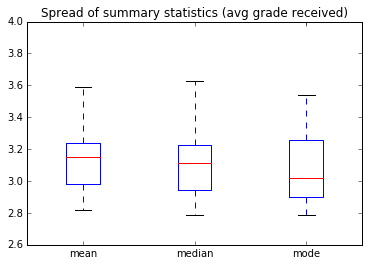

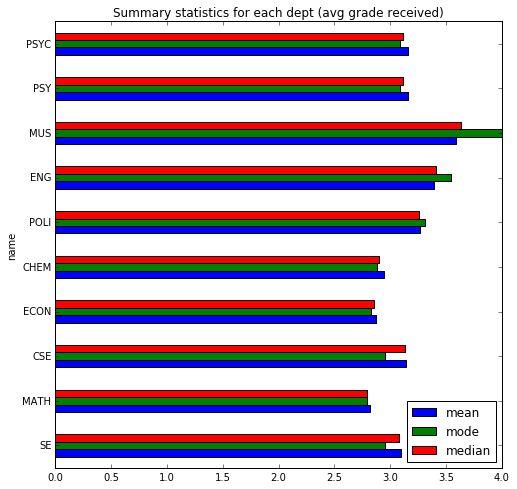

In [16]:
summary_stats = pd.DataFrame( \
         { 'name' : code,
           'mean' : cape["avg grade received"].mean(),
           'mode' : cape["avg grade received"].mode()[0],
           'median' : cape["avg grade received"].median()
         } for code, cape in zip(data_files, cape_data)
    )

summary_stats.plot(title='Spread of summary statistics (avg grade received)', kind='box')
summary_stats.plot(title='Summary statistics for each dept (avg grade received)',
                   kind='barh', x = 'name', y = ['mean', 'mode', 'median'], figsize=(8, 8))

### 6b. Can we find any correlations between pairs of variables for any of the departments?

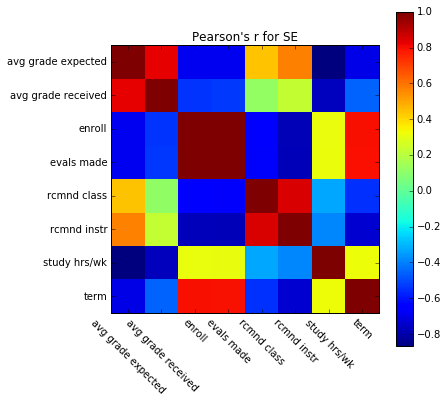

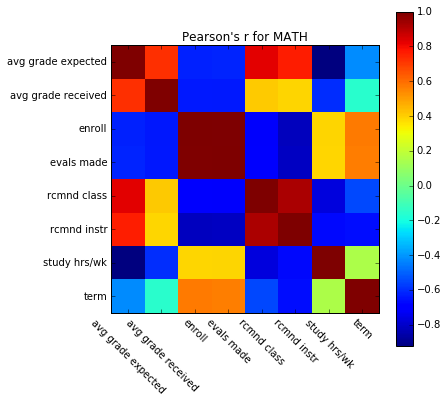

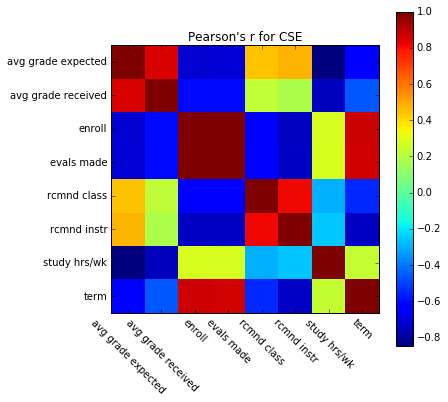

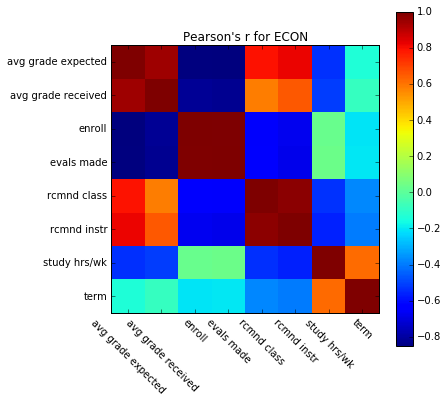

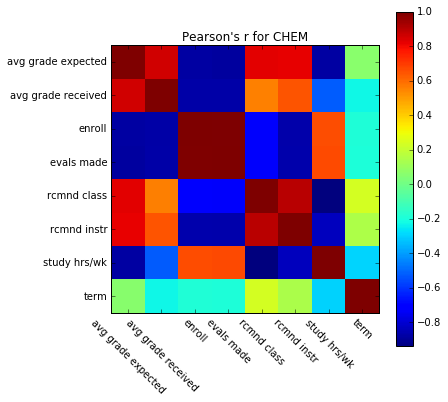

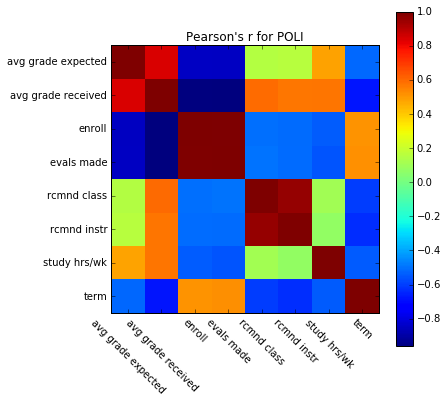

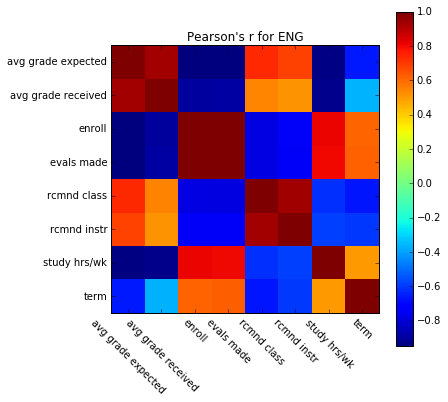

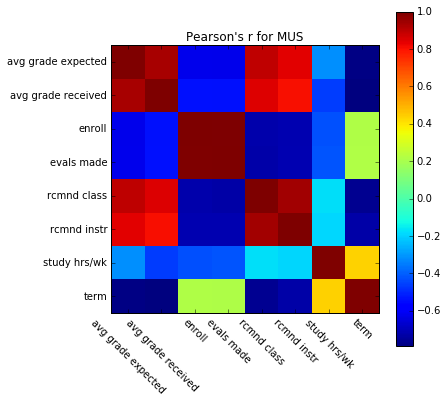

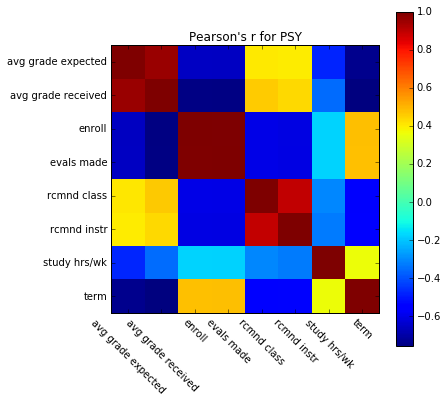

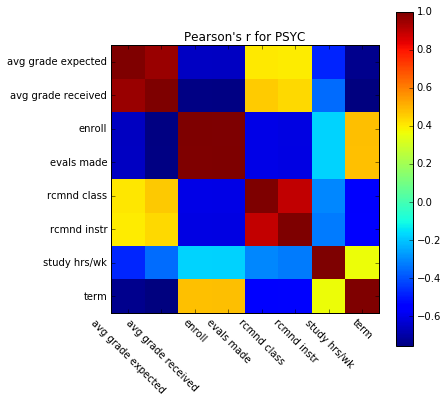

In [17]:
for code, cape in zip(data_files, cape_data):
    # Only use CAPE entries where response rate > 80%
    cape = cape[cape['evals made'] / cape['enroll'] > 0.8].corr()
    
    # Credit for correlation matrix generation to Assignment #3 writeup
    col_labels = [col.encode('utf8') for col in cape.corr().columns]
    plt.figure(figsize=(6,6))
    plt.imshow(cape.corr(),interpolation='none') 
    plt.xticks(range(len(col_labels)), col_labels, rotation=-45)
    plt.yticks(range(len(col_labels)), col_labels)
    plt.colorbar()
    
    plt.title("Pearson's r for {0}".format(code))

### 6c. Are the potential correlations consistent across departments?

The first three most common positive correlations are reassuring and make some sense.  

    A higher class recommendation rating positively corresponds with instructor rating.  
    A higher enrollment count positively corresponds with the number of evaluations made.  
    The expected grade positively corresponds with the actual received grade.  

Of note, however, is the fact that there are more departments with a positive correlation between 'avg grade expected' and 'rcmnd class' than there are departments with the same correlation for 'avg grade received and rcmnd class'.

In [18]:
num_correlations = {}

for code, cape in zip(data_files, cape_data):
    # Only use CAPE entries where response rate > 80%
    cape = cape[cape['evals made'] / cape['enroll'] > 0.8].corr()

    # Select entries where correlation score is greater than 0.5
    indices = np.where(cape >= 0.5)
    indices = [ cape.index[x] + "," + cape.columns[y] for x, y in zip(*indices)
                                        if x != y and x < y]
    
    for coords in indices:
        if num_correlations.get(coords):
            num_correlations[coords] += 1
        else:
            num_correlations[coords] = 1

print "Number of department subjects with correlation score >= 0.5"
correlations = [pair.split(',') + [value] for pair, value in num_correlations.iteritems()]
pd.DataFrame(correlations, columns=['x', 'y', 'departments']). \
    sort_values(by='departments', ascending=False).reset_index(drop=True)

Number of department subjects with correlation score >= 0.5


,x,y,departments
0,rcmnd class,rcmnd instr,10
1,enroll,evals made,10
2,avg grade expected,avg grade received,10
3,avg grade expected,rcmnd class,4
4,enroll,term,2
5,evals made,term,2
6,avg grade received,rcmnd class,2
7,avg grade expected,rcmnd instr,2
8,avg grade received,study hrs/wk,1


In [19]:
num_correlations = {}

for code, cape in zip(data_files, cape_data):
    # Only use CAPE entries where response rate > 80%
    cape = cape[cape['evals made'] / cape['enroll'] > 0.8].corr()

    # Select entries where correlation score is greater than 0.5
    indices = np.where(cape <= -0.5)
    indices = [ cape.index[x] + "," + cape.columns[y] for x, y in zip(*indices)
                                        if x != y and x < y]
    
    for coords in indices:
        if num_correlations.get(coords):
            num_correlations[coords] += 1
        else:
            num_correlations[coords] = 1

print "Number of department subjects with correlation score <= -0.5"
correlations = [pair.split(',') + [value] for pair, value in num_correlations.iteritems()]
pd.DataFrame(correlations, columns=['x', 'y', 'departments']). \
    sort_values(by='departments', ascending=False).reset_index(drop=True)

Number of department subjects with correlation score <= -0.5


,x,y,departments
0,avg grade expected,study hrs/wk,3
1,avg grade expected,enroll,1
2,rcmnd class,study hrs/wk,1
3,avg grade expected,evals made,1


### 6c. Can we find a correlation between grades received over time at the instructor level?

In order to reduce screen clutter, we will only be using the professor from each subject department who has taught the most classes.

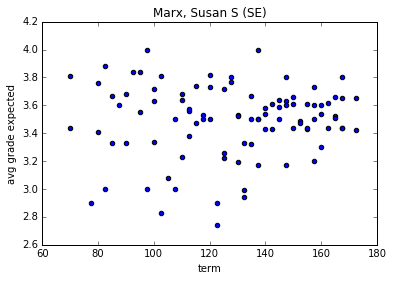

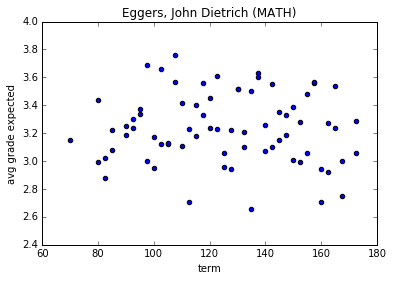

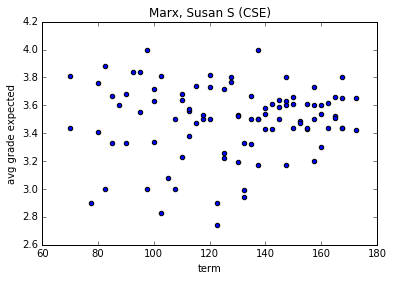

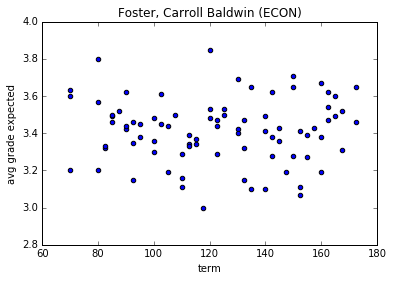

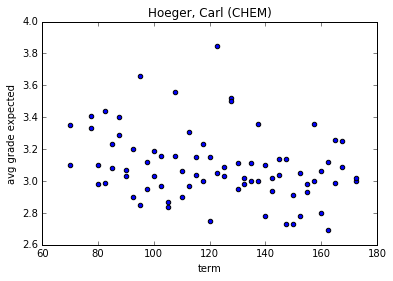

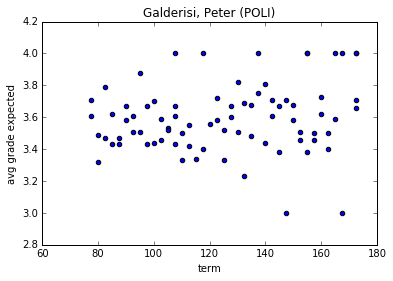

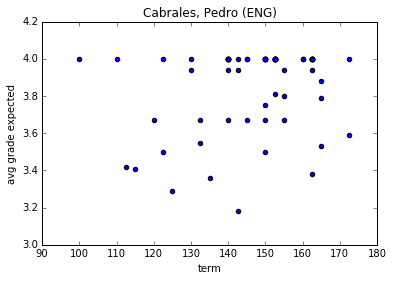

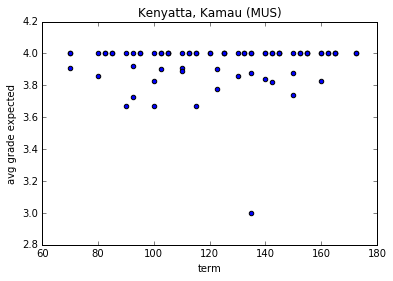

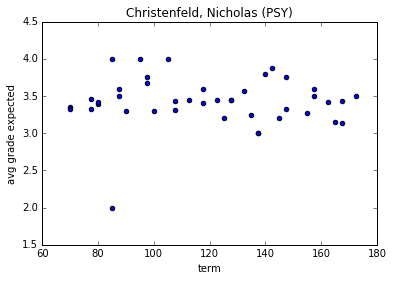

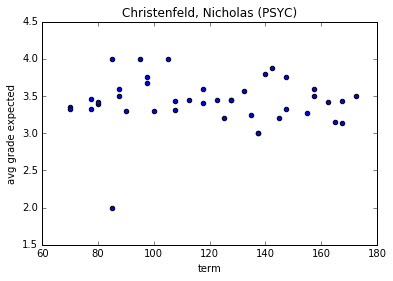

In [20]:
for code, cape in zip(data_files, cape_data):
    professor = cape.instructor.value_counts().index[0]
    prof_data = cape[cape.instructor == professor].plot( \
        kind='scatter', title=professor + " ({0})".format(code), x='term', y='avg grade expected')

### 6d. Can we find a correlation between grades received over time at the department subject level?

,department,correlation (term / avg grade received)
0,POLI,0.739851
1,SE,0.642512
2,CSE,0.630753
3,MATH,0.596789
4,PSY,0.527515
5,PSYC,0.527515
6,ENG,0.510498
7,MUS,0.381733
8,CHEM,0.312571
9,ECON,0.199074


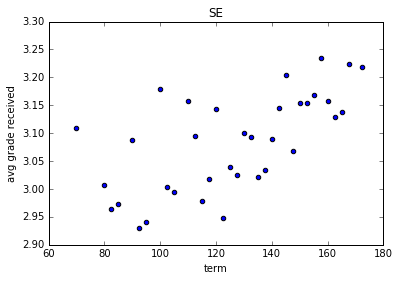

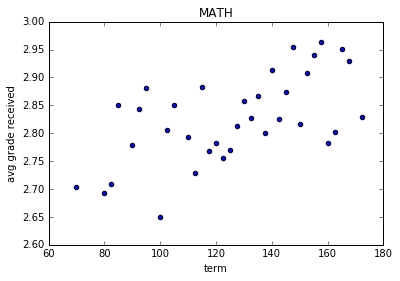

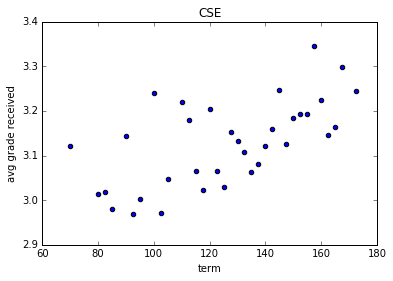

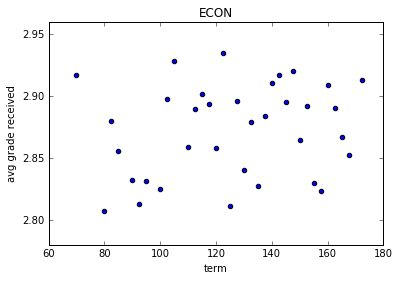

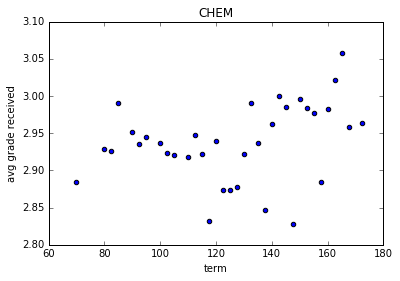

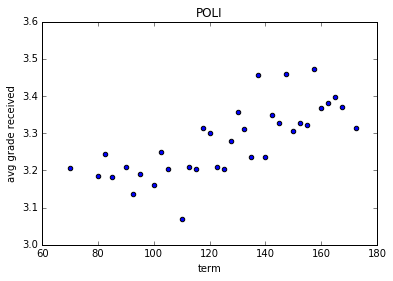

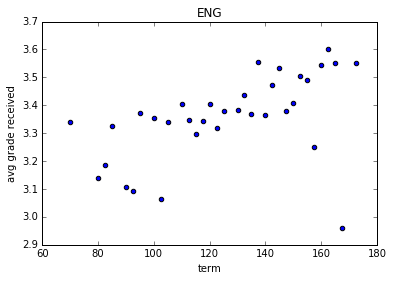

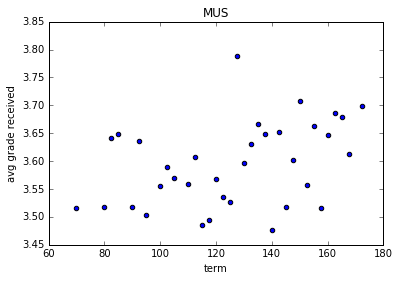

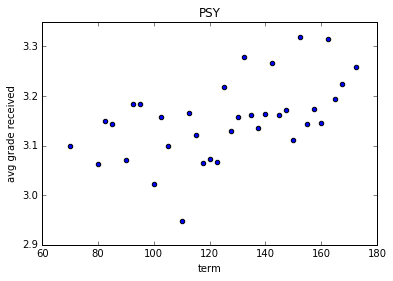

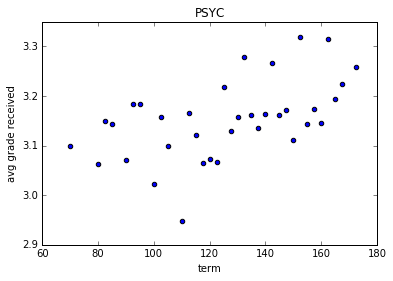

In [21]:
correlations = []

for code, cape in zip(data_files, cape_data):
    term_gpa = cape.groupby('term')['avg grade received'].mean()
    
    df = pd.DataFrame( \
        {'term': term_gpa.index,
         'avg grade received': term_gpa.values}
    )
    df.plot(kind='scatter', title=code, x='term', y='avg grade received')
    
    correlations.append([code, df.term.corr(df['avg grade received'])])

correlations.sort(key=lambda pair: pair[1], reverse=True)
pd.DataFrame(correlations, columns=['department', 'correlation (term / avg grade received)'])